In [62]:
import numpy as np
import pandas as pd
import kagglehub
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import DropMissingData
from feature_engine.encoding import OneHotEncoder

Load Data

In [63]:
def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):
  """
  This function compares the distribution of variables before and after data cleaning.

  Parameters:
  df_original (DataFrame): The original DataFrame before cleaning.
  df_cleaned (DataFrame): The DataFrame after cleaning.
  variables_applied_with_method (list): The list of variables that the cleaning method was applied to.
  """

  flag_count=1 # Counter to keep track of the plot number
  
  # Identify categorical variables in the original DataFrame
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # Loop over the variables that the cleaning method was applied to
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  
    # For each variable, plot its distribution before and after cleaning
    for var in set_of_variables:
      if var in categorical_variables:  # If the variable is categorical, use a barplot
        # Create DataFrames for the original and cleaned data
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        # Concatenate the two DataFrames
        dfAux = pd.concat([df1, df2], axis=0)
        # Create the plot
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # If the variable is numerical, use a histogram
        # Create the plot
        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend()

In [64]:
def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop over each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing values in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(20, 5))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show();
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.show();


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked

In [40]:
df = pd.read_csv('Donations_accepted_by_political_parties.csv', dtype={
    'index': 'int64',
    'ECRef' : 'object',
    'RegulatedEntityName': 'string',
    'RegulatedEntityType': 'string',
    'Value': 'string',
    "AcceptedDate": 'string',
    "AccountingUnitName": 'string',
    "DonorName": 'string',
    "AccountingUnitsAsCentralParty": 'bool',
    'IsSponsorship': 'bool',
    'DonorStatus': 'string',
    'RegulatedDoneeType': 'string',
    'CompanyRegistrationNumber': 'string',
    'Postcode': 'string',
    'DonationType': 'string',
    'NatureOfDonation': 'string',
    'PurposeOfVisit': 'string',
    'DonationAction': 'string',
    'ReceivedDate': 'string',
    'ReportedDate': 'string',
    'IsReportedPrePoll': 'string',
    'ReportingPeriodName': 'string',
    'IsBequest': 'bool',
    'IsAggregation': 'bool',
    'RegulatedEntityId': 'string',
    'AccountingUnitId': 'string',
    'DonorId': 'object',
    'CampaigningName': 'string',
    'RegisterName': 'string',
    'IsIrishSource': 'string'
    },index_col="index")

# DataSummary
summary_df = pd.DataFrame({
    'DataType': df.dtypes,
    'UniqueValues': df.nunique(),
    'RowsWithData': len(df)-df.isnull().sum(),
    'NullValues':df.isnull().sum(),
    'SkewScore':df.skew(),
    'Kurtosis':df.kurtosis()
}).reset_index().rename(columns={'index': 'Column'})
summary_df

,Column,DataType,UniqueValues,RowsWithData,NullValues,SkewScore,Kurtosis
0,AcceptedDate,string,6265,64265,1013,NaN,NaN
1,AccountingUnitId,string,2185,36355,28923,NaN,NaN
2,AccountingUnitName,string,1856,56957,8321,NaN,NaN
3,AccountingUnitsAsCentralParty,bool,2,65278,0,3.972770,13.783323
4,CampaigningName,string,3,5,65273,NaN,NaN
5,CompanyRegistrationNumber,string,3558,11480,53798,NaN,NaN
6,DonationAction,string,3,283,64995,NaN,NaN
7,DonationType,string,9,65278,0,NaN,NaN
8,DonorId,object,44739,65197,81,0.630278,-0.531133
9,DonorName,string,19010,65193,85,NaN,NaN


In [41]:
# Remove Currency sign of Value and convert to Float
df['Value'] = df['Value'].replace({'\£': '', ',': ''}, regex=True).astype(float)
# Fill blank ReceivedDate with ReportedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportedDate'])
# Fill blank ReceivedDate with AcceptedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['AcceptedDate'])
# convert Received date to Date Format
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'], format='%d/%m/%Y', errors='coerce')
# Convert 'ReportingPeriodName' to datetime if it contains dates at the e
df['ReportingPeriodName_Date'] = pd.to_datetime(
    df['ReportingPeriodName'].str.strip().str[-10:],
    dayfirst=True,
    format='mixed', 
    errors='coerce'
)
# Fill missing 'ReceivedDate' with extracted dates from 'ReportingPeriodName'
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportingPeriodName_Date'])
# Append YearReceived column 
df['YearReceived'] = round(df['ReceivedDate'].dt.year)
# Append MonthReceived column 
df['MonthReceived'] = round(df['ReceivedDate'].dt.month)
# Create YearMonthReceived Column
df['YearMonthReceived'] = round(df['YearReceived']*100 +df['MonthReceived'])
# drop unrequired Columns
df = df.drop(['IsIrishSource', 'RegisterName', 'CampaigningName','AccountingUnitName','AccountingUnitsAsCentralParty','AccountingUnitId','ReportedDate','AcceptedDate','PurposeOfVisit','IsReportedPrePoll', 'ReportingPeriodName_Date'], axis=1)
# drop blank ReceivedDate, DonorID or regulatedEntityName
df = df.dropna(subset = ['ReceivedDate', 'RegulatedEntityName','DonorId','DonorName'])

Review Data to identify Unnecessary Columns and Potential improved Index

In [42]:
# DataSummary post clean
summary_df2 = pd.DataFrame({
    'DataType': df.dtypes,
    'UniqueValues': df.nunique(),
    'RowsWithData': len(df)-df.isnull().sum(),
    'NullValues':df.isnull().sum(),
    'SkewScore':df.skew(),
    'Kurtosis':df.kurtosis()
}).reset_index().rename(columns={'index': 'Column'})
summary_df2

,Column,DataType,UniqueValues,RowsWithData,NullValues,SkewScore,Kurtosis
0,CompanyRegistrationNumber,string,3558,11480,53713,NaN,NaN
1,DonationAction,string,3,256,64937,NaN,NaN
2,DonationType,string,7,65193,0,NaN,NaN
3,DonorId,object,44736,65193,0,0.630371,-0.530975
4,DonorName,string,19010,65193,0,NaN,NaN
5,DonorStatus,string,12,65193,0,NaN,NaN
6,ECRef,object,65193,65193,0,NaN,NaN
7,IsAggregation,bool,2,65193,0,1.165368,-0.641938
8,IsBequest,bool,2,65193,0,9.310707,84.691867
9,IsSponsorship,bool,2,65193,0,8.826138,75.903047


Review DonorStatus, DonationAction, DonationType, NatureOfDonation

In [43]:
print(df.groupby('DonorStatus').Value.agg(['sum', 'count']))
print()
print(df.groupby('DonationAction').RegulatedEntityName.agg('count'))
print()
print(df.groupby('DonationType').RegulatedEntityName.agg('count'))
print()
print(df.groupby('NatureOfDonation').Value.agg(['sum', 'count']))
print()
print(df.groupby('IsAggregation').Value.agg(['sum', 'count', 'mean']).round(1))
print()
print(df.groupby('DonationType').Value.agg(['min', 'max', 'sum', 'count', 'mean', 'median']))

                                        sum  count
DonorStatus                                       
Building Society               1.285415e+04      3
Company                        1.892561e+08  11883
Friendly Society               1.522612e+07    659
Impermissible Donor            7.915091e+05    254
Individual                     4.603920e+08  29430
Limited Liability Partnership  7.936854e+06    477
Other                          8.463631e+06   1757
Public Fund                    1.642891e+08   1726
Registered Political Party     3.164690e+06   1029
Trade Union                    1.928190e+08   9926
Trust                          4.855774e+06    640
Unincorporated Association     4.407400e+07   7409

DonationAction
Deferred      16
Forfeited     20
Returned     220
Name: RegulatedEntityName, dtype: int64

DonationType
Cash                              51642
Exempt Trust                        469
Impermissible Donor                 256
Non Cash                           8308
Permi

In [44]:
# create Value_Category based on 10 equal volumed buckets
Groupings = 10
Value_Category_two = pd.qcut(df['Value'],q=Groupings)
df = pd.concat([Value_Category_two, df],axis=1, join="inner")
df.columns.values[0]='Value_Category'


In [45]:
RegulatedEntity_df = df.groupby('RegulatedEntityName').agg({'Value': ['sum', 'count', 'mean']})

RegulatedEntity_df.columns = [ 'DonationsValue', 'DonationEvents', 'DonationMean']

RegulatedEntity_df

,DonationsValue,DonationEvents,DonationMean
RegulatedEntityName,,,
Abisola Ifasawo,1650.00,1,1650.000000
Alan Brown,5100.00,1,5100.000000
Alan Mak MP,27693.61,9,3077.067778
Alec Shelbrooke,4860.00,2,2430.000000
Alex Burghart,7800.00,1,7800.000000
...,...,...,...
Yvonne Fovargue MP,6758.06,2,3379.030000
Zac Goldsmith MP,50000.00,1,50000.000000
mums4justice [De-registered 16/05/11],105869.75,12,8822.479167


In [46]:
# Define a function to set the category
def RegulatedEntityGroup(RegulatedEntityNameVar):
    # Define Dictionary with grouped values
    RegEntityGrouping = {0:'No Relevant Donations', 1: 'Single Donation Entity', 10: 'Very Small Entity', 50: 'Small Entity', 100: 'Medium Entity', float('inf'): RegulatedEntityNameVar}
    # Select all relevant donation events for specified Entity Name    
    RE_Events = RegulatedEntity_df[RegulatedEntity_df.index == RegulatedEntityNameVar]
    #Compare Count of events to rangelimits in Dictionary and return Category
    for rangeLimit, category in RegEntityGrouping.items():
        if RE_Events.DonationEvents.agg(sum) <= rangeLimit:
            return category

# Apply the function to create a new column
df['RegEntity_Group'] = df.RegulatedEntityName.apply(RegulatedEntityGroup)
# Summary of update from above
df.groupby(['RegEntity_Group']).agg({'Value': ['sum', 'count', 'mean']})

Value         \
                                                          sum  count   
RegEntity_Group                                                        
British National Party [De-registered 08/01/16]  1.406959e+06    142   
Co-operative Party                               1.492238e+07    534   
Conservative and Unionist Party                  4.194008e+08  20351   
Green Party                                      4.976511e+06   1045   
Labour Party                                     3.574923e+08  18121   
Liberal Democrats                                9.682764e+07  12125   
Medium Entity                                    1.914971e+07   1657   
Mr Boris Johnson MP                              1.514047e+06    141   
Plaid Cymru - The Party of Wales                 6.037126e+06    387   
Progress Ltd                                     4.706893e+06    114   
Scottish National Party (SNP)                    2.187422e+07    660   
Scottish Socialist Party                         5.584151e+05    145   
Single Donation Entity                           2.912942e+06    488   
Sinn Féin                                        2.506699e+06    359   
Small Entity                                     4.364938e+07   3756   
The In Campaign Ltd                              2.422811e+07    206   
The New Party [De-registered 01/07/10]           1.382820e+06    146   
UK Independence Party (UKIP)                     1.779199e+07   1809   
Very Small Entity                                3.027103e+07   2756   
Vote Leave Limited                               1.967164e+07    251   

                                                                
                                                          mean  
RegEntity_Group                                                 
British National Party [De-registered 08/01/16]    9908.164225  
Co-operative Party                                27944.522603  
Conservative and Unionist Party                   20608.363216  
Green Party                                        4762.211359  
Labour Party                                      19728.068602  
Liberal Democrats                                  7985.784353  
Medium Entity                                     11556.855335  
Mr Boris Johnson MP                               10737.922908  
Plaid Cymru - The Party of Wales                  15599.807597  
Progress Ltd                                      41288.536491  
Scottish National Party (SNP)                     33142.755803  
Scottish Socialist Party                           3851.138552  
Single Donation Entity                             5969.143115  
Sinn Féin                                          6982.448774  
Small Entity                                      11621.240732  
The In Campaign Ltd                              117612.180097  
The New Party [De-registered 01/07/10]             9471.369041  
UK Independence Party (UKIP)                       9835.260857  
Very Small Entity                                 10983.681720  
Vote Leave Limited                                78373.079681

In [47]:
ElectionDates = ['2001/06/07 00:00:00','2005/05/05 00:00:00','2010/06/05 00:00:00', '2015/07/05 00:00:00', '2017/07/05 00:00:00', '2019/12/12 00:00:00', '2024/07/04 00:00:00']

def GenElectionRelation(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = DaysDiff.days
            return delta
        else:
            pass
    return 0

df['DaysToNextElection'] = df.ReceivedDate.apply(GenElectionRelation)


In [48]:
def GenElectionRelation2(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = math.ceil((DaysDiff.days)/7)
            return delta
        else:
            pass
    return 0

df['WeeksToNextElection'] = df.ReceivedDate.apply(GenElectionRelation2)

In [49]:
def GenElectionRelation3(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = math.ceil((DaysDiff.days)/91)
            return delta
        else:
            pass
    return 0

df['QtrsToNextElection'] = df.ReceivedDate.apply(GenElectionRelation3)

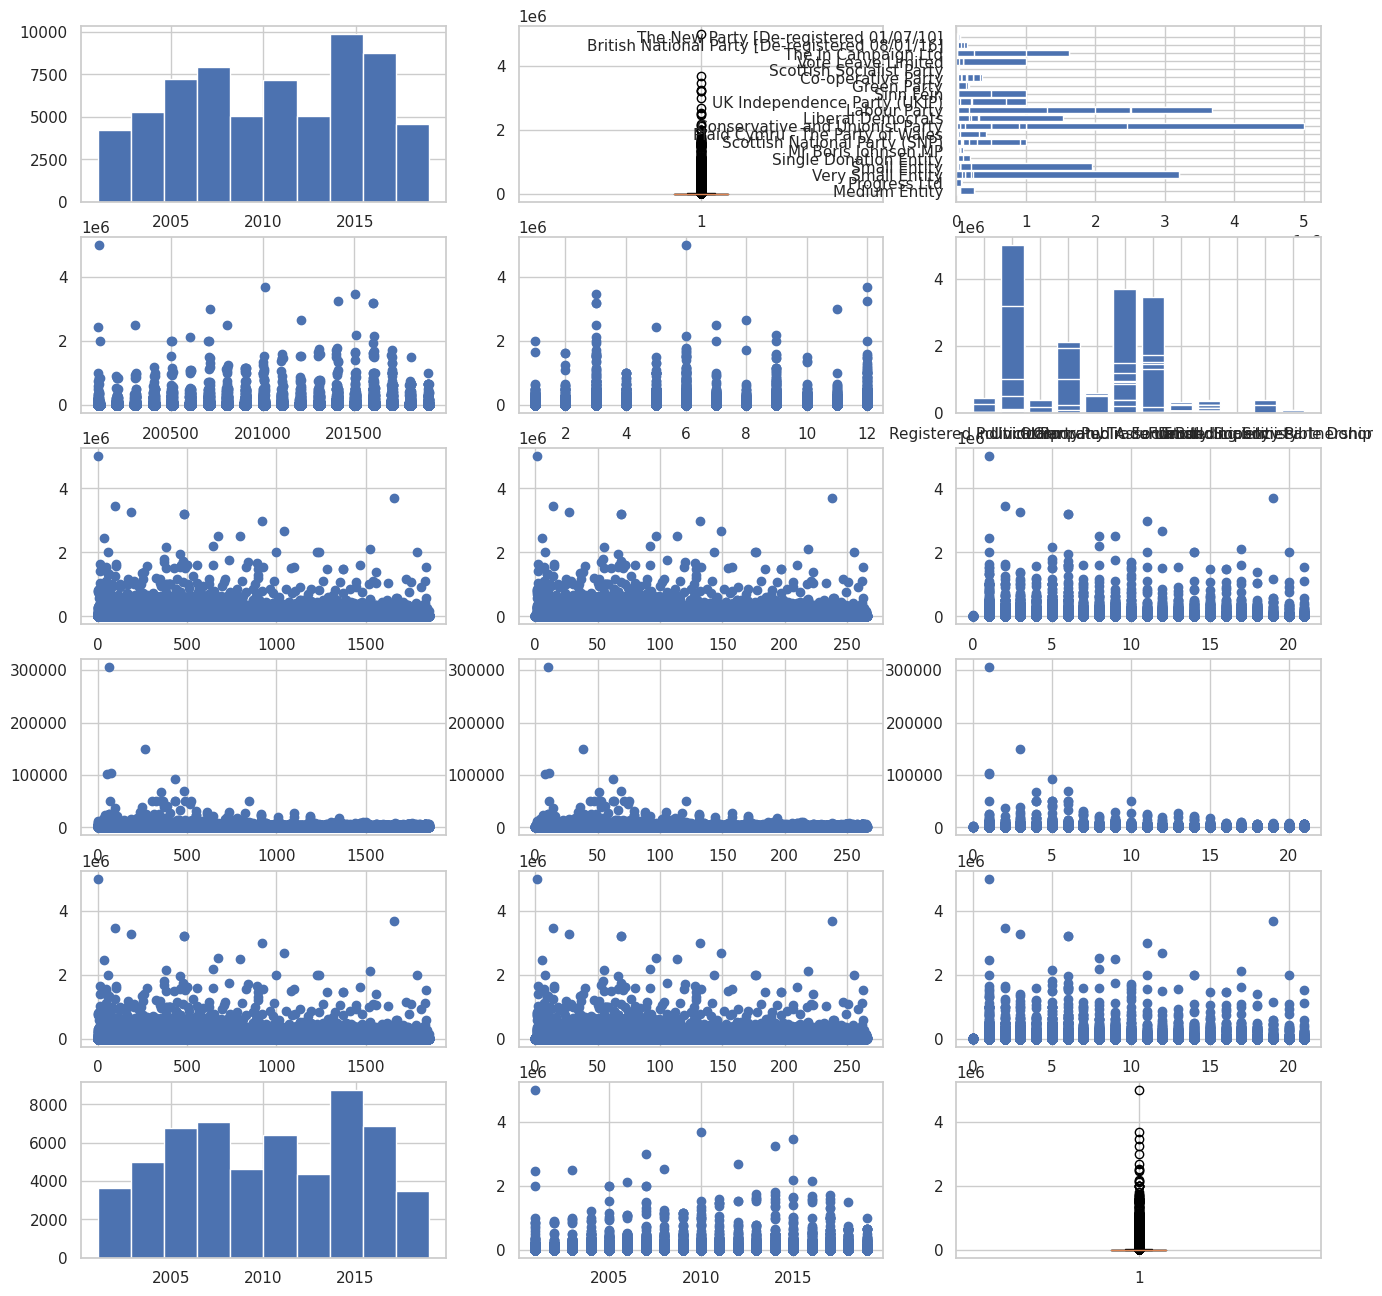

In [50]:

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,16))

axes[0,0].hist(df["YearReceived"])
axes[0,1].boxplot(x=df['Value'] )
axes[0,2].barh(y=df['RegEntity_Group'], width = df['Value'])
axes[1,0].scatter(x=df['YearMonthReceived'], y =df['Value'])
axes[1,1].scatter(x=df['MonthReceived'], y=df['Value'])
axes[1,2].bar(x=df['DonorStatus'], height=df['Value'])
axes[2,0].scatter(x=df['DaysToNextElection'], y=df['Value'])
axes[2,1].scatter(x=df['WeeksToNextElection'], y=df['Value'])
axes[2,2].scatter(x=df['QtrsToNextElection'], y=df['Value'])
axes[3,0].scatter(data=df[df['IsAggregation']==True], x='DaysToNextElection', y='Value')
axes[3,1].scatter(data=df[df['IsAggregation']==True], x='WeeksToNextElection', y='Value')
axes[3,2].scatter(data=df[df['IsAggregation']==True], x='QtrsToNextElection', y='Value')
axes[4,0].scatter(data=df[df['IsAggregation']==False], x='DaysToNextElection', y='Value')
axes[4,1].scatter(data=df[df['IsAggregation']==False], x='WeeksToNextElection', y='Value')
axes[4,2].scatter(data=df[df['IsAggregation']==False], x='QtrsToNextElection', y='Value')
axes[5,0].hist(data=df[df['RegulatedEntityType']=='Political Party'], x='YearReceived')
axes[5,1].scatter(data=df[df['RegulatedEntityType']=='Political Party'], x='YearReceived', y='Value')
axes[5,2].boxplot(data=df[df['RegulatedEntityType']=='Political Party'], x='Value')
#df.plot(df[['Value_Category', 'RegulatedEntityType', 'DonorStatus', 'YearReceived']])
plt.show()


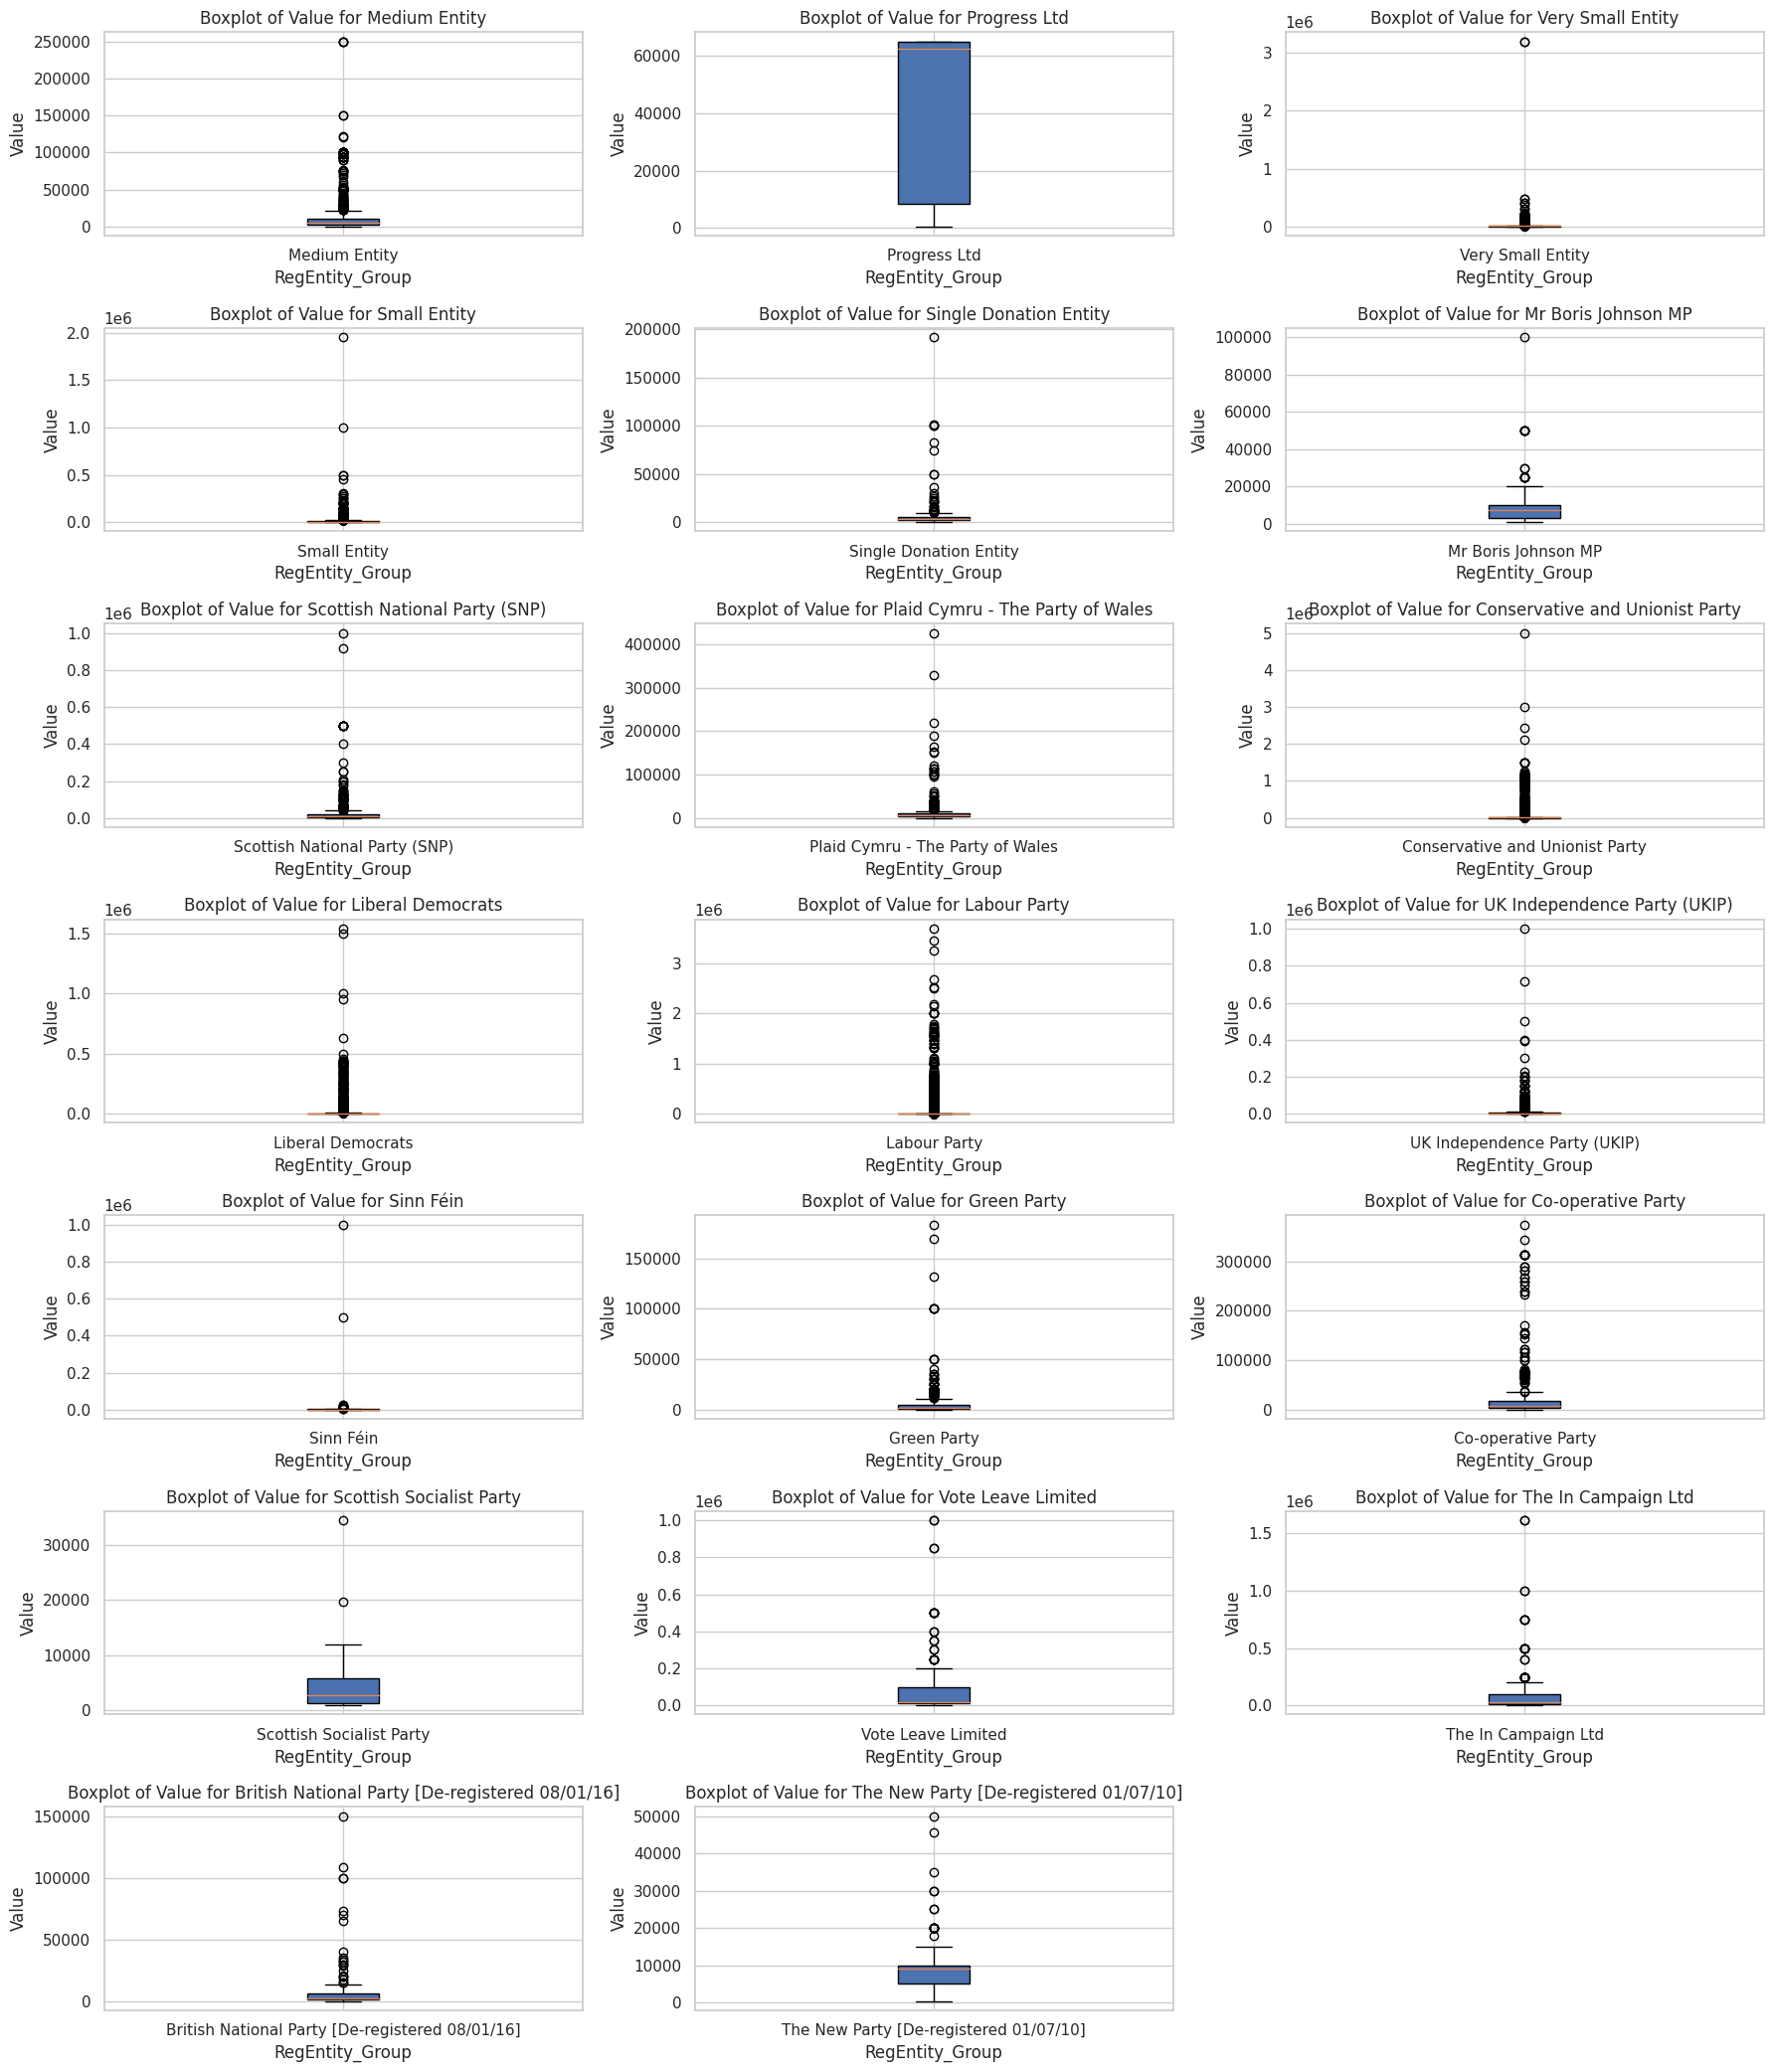

In [51]:
# Get unique values in RegEntity_Group
unique_groups = df['RegEntity_Group'].unique()

# Number of plots per row
plots_per_row = 3

# Calculate the required number of rows
num_rows = math.ceil(len(unique_groups) / plots_per_row)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(18, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each unique value in RegEntity_Group and corresponding axes
for idx, group in enumerate(unique_groups):
    # Filter data for the current group
    group_data = df.loc[df['RegEntity_Group'] == group, 'Value'].dropna()
    
    # Create a boxplot for the current group
    axes[idx].boxplot(group_data, vert=True, patch_artist=True, labels=[group])
    
    # Add labels and title
    axes[idx].set_title(f'Boxplot of Value for {group}')
    axes[idx].set_ylabel('Value')
    axes[idx].set_xlabel('RegEntity_Group')

# Hide any unused axes
for ax in axes[len(unique_groups):]:
    ax.set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()



In [52]:
# DataSummary post clean
summary_df2 = pd.DataFrame({
    'DataType': df.dtypes,
    'UniqueValues': df.nunique(),
    'RowsWithData': len(df)-df.isnull().sum(),
    'NullValues':df.isnull().sum(),
    'SkewScore':df.skew(),
    'Kurtosis':df.kurtosis()
}).reset_index().rename(columns={'index': 'Column'})
summary_df2

,Column,DataType,UniqueValues,RowsWithData,NullValues,SkewScore,Kurtosis
0,CompanyRegistrationNumber,string,3558,11480,53713,NaN,NaN
1,DaysToNextElection,int64,1846,65193,0,0.724350,-0.566593
2,DonationAction,string,3,256,64937,NaN,NaN
3,DonationType,string,7,65193,0,NaN,NaN
4,DonorId,object,44736,65193,0,0.630371,-0.530975
5,DonorName,string,19010,65193,0,NaN,NaN
6,DonorStatus,string,12,65193,0,NaN,NaN
7,ECRef,object,65193,65193,0,NaN,NaN
8,IsAggregation,bool,2,65193,0,1.165368,-0.641938
9,IsBequest,bool,2,65193,0,9.310707,84.691867


* Variable Analyzed: Value
* Applied transformation: ['Value_power', 'Value_yeo_johnson'] 



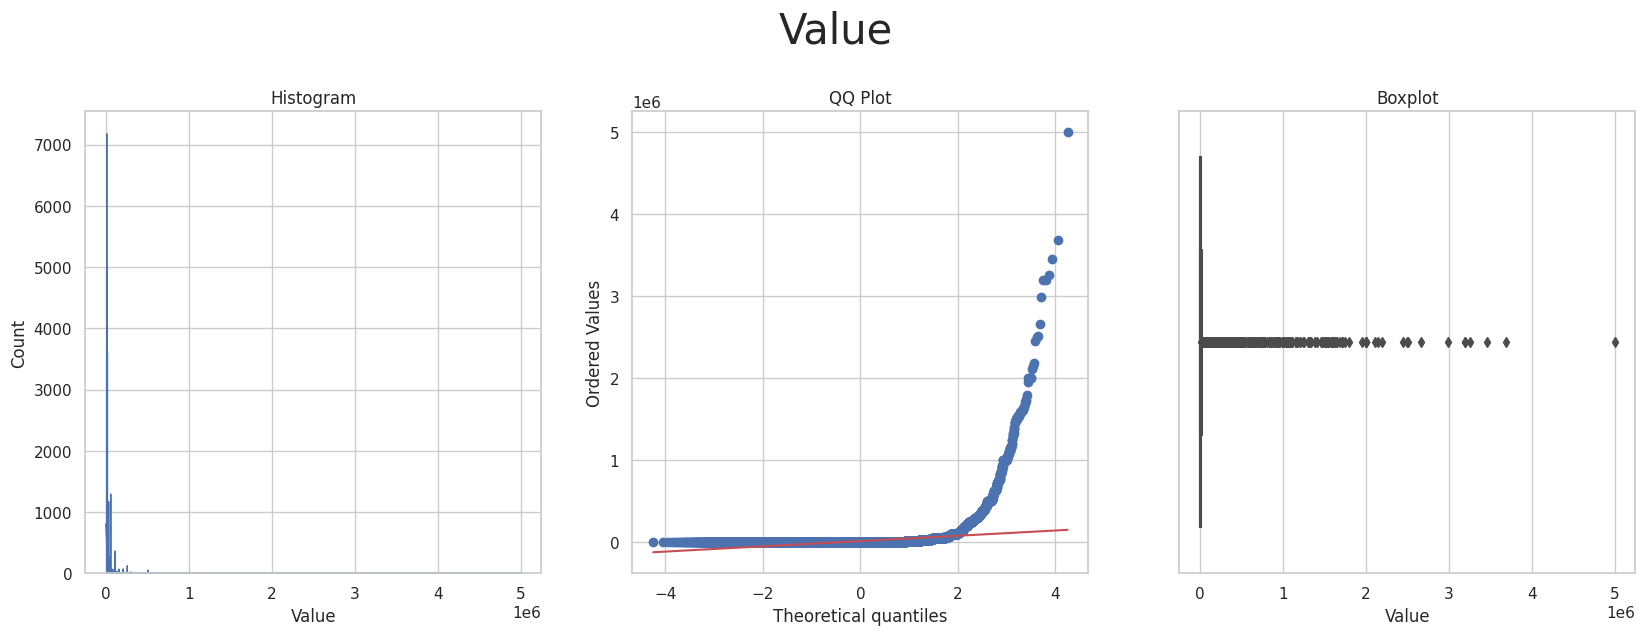

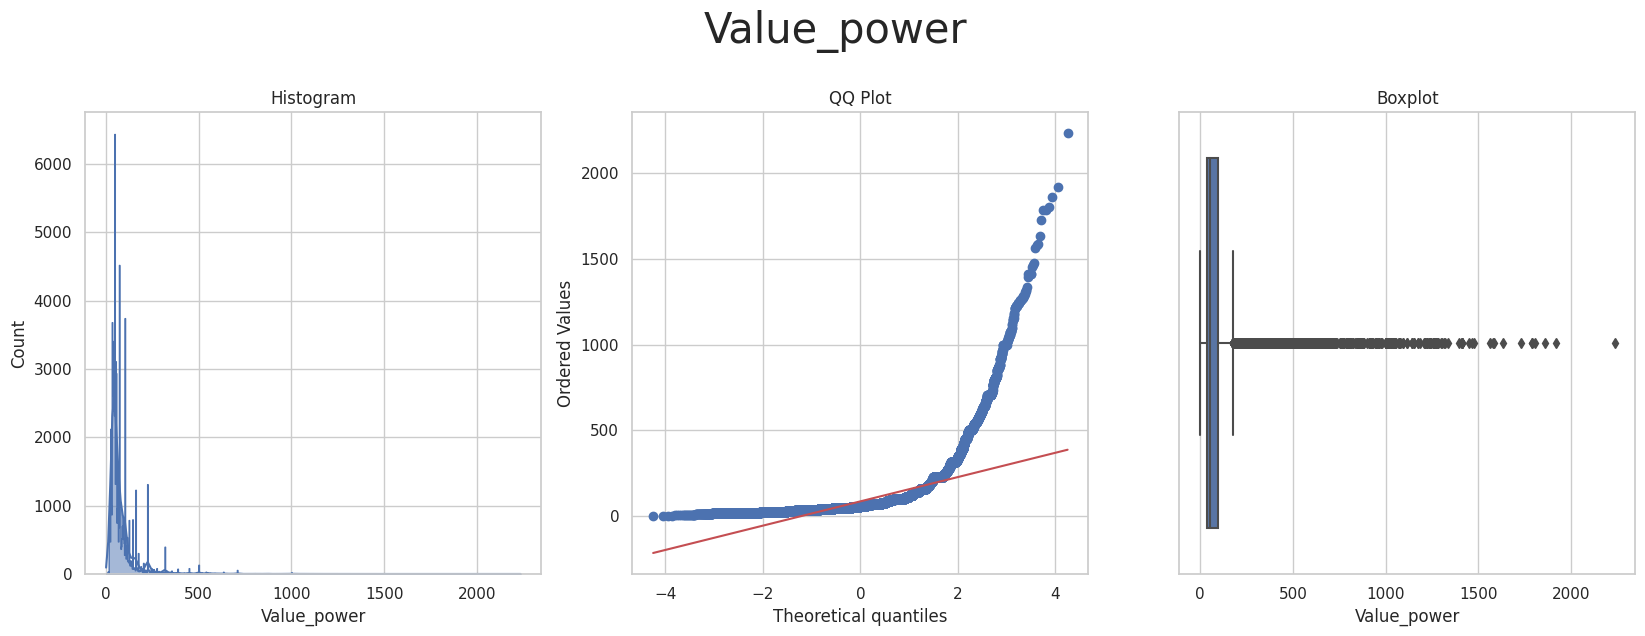

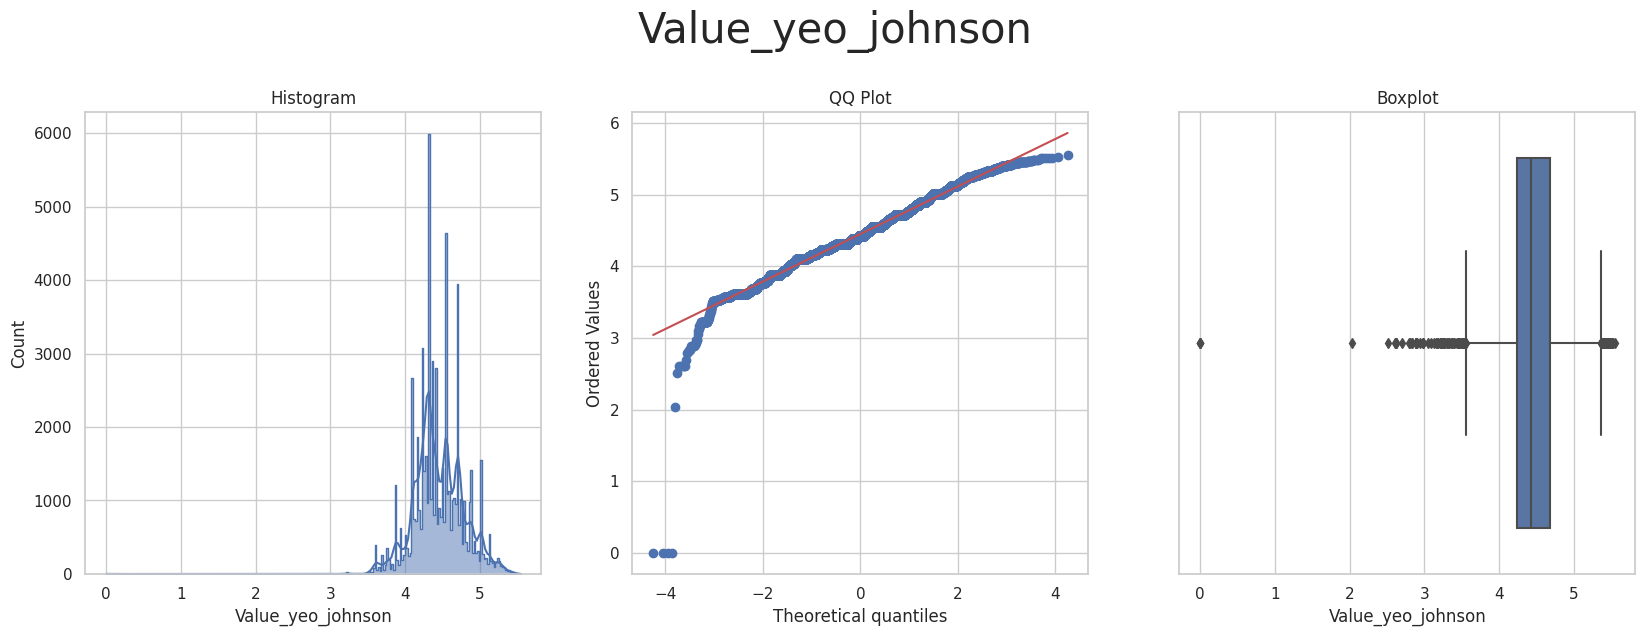

In [65]:
variables_engineering= ['Value']
df_engineering = df[variables_engineering].copy()
# 'numerical', 'ordinal_encoder',  'outlier_winsorizer'
df_engineering = FeatureEngineeringAnalysis(df=df_engineering.dropna(),analysis_type='numerical')

* Variable Analyzed: RegEntity_Group
* Applied transformation: ['RegEntity_Group_ordinal_encoder'] 



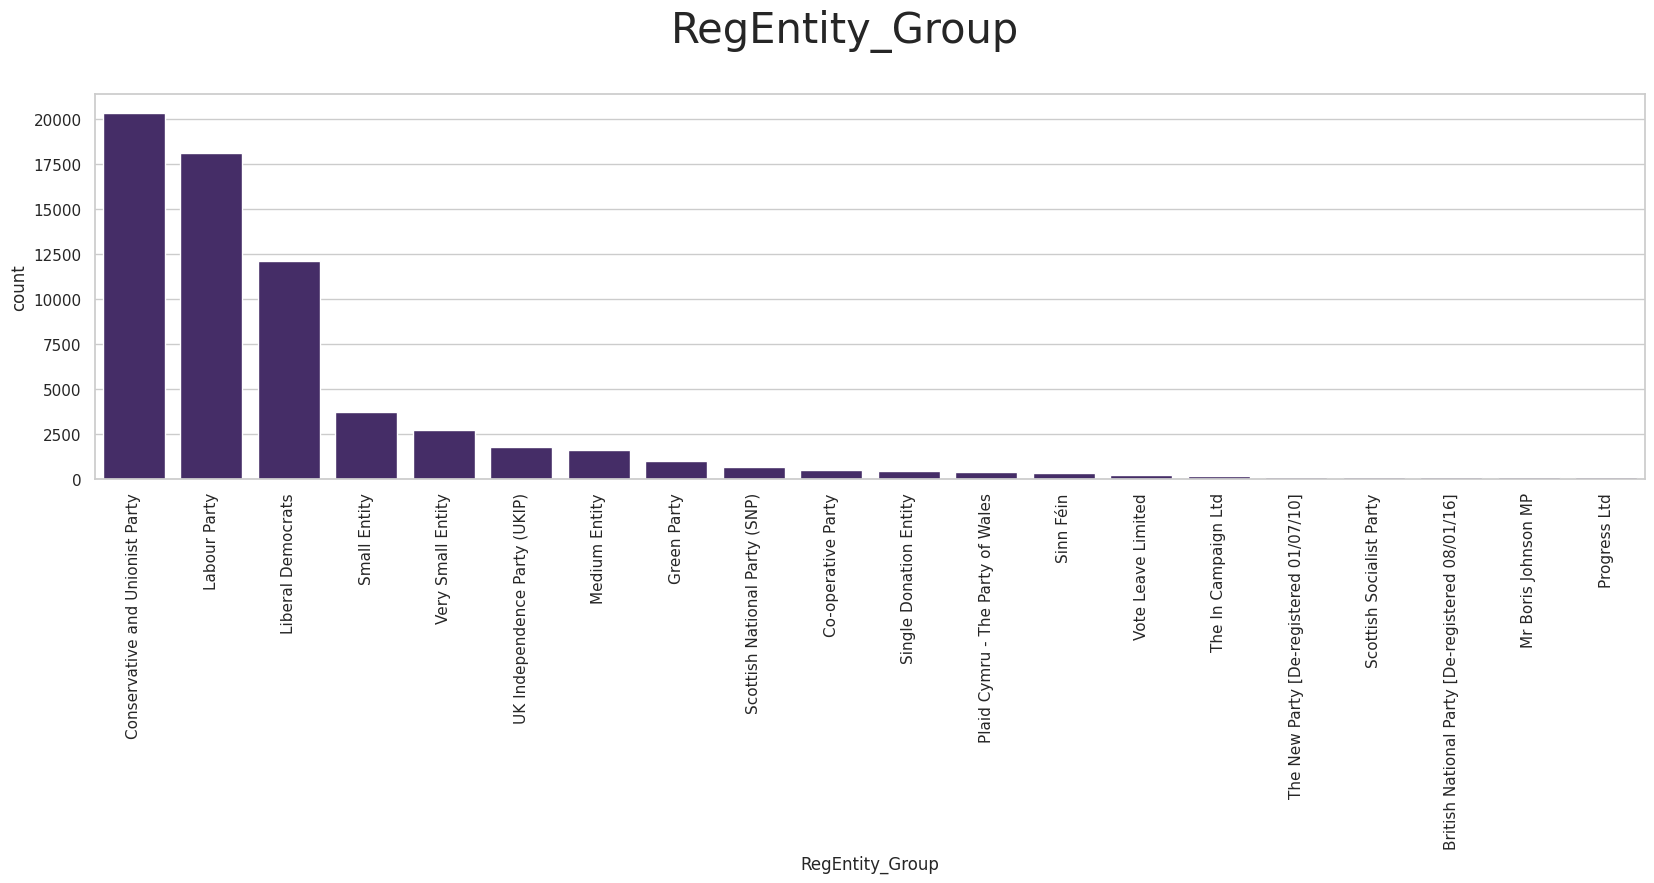

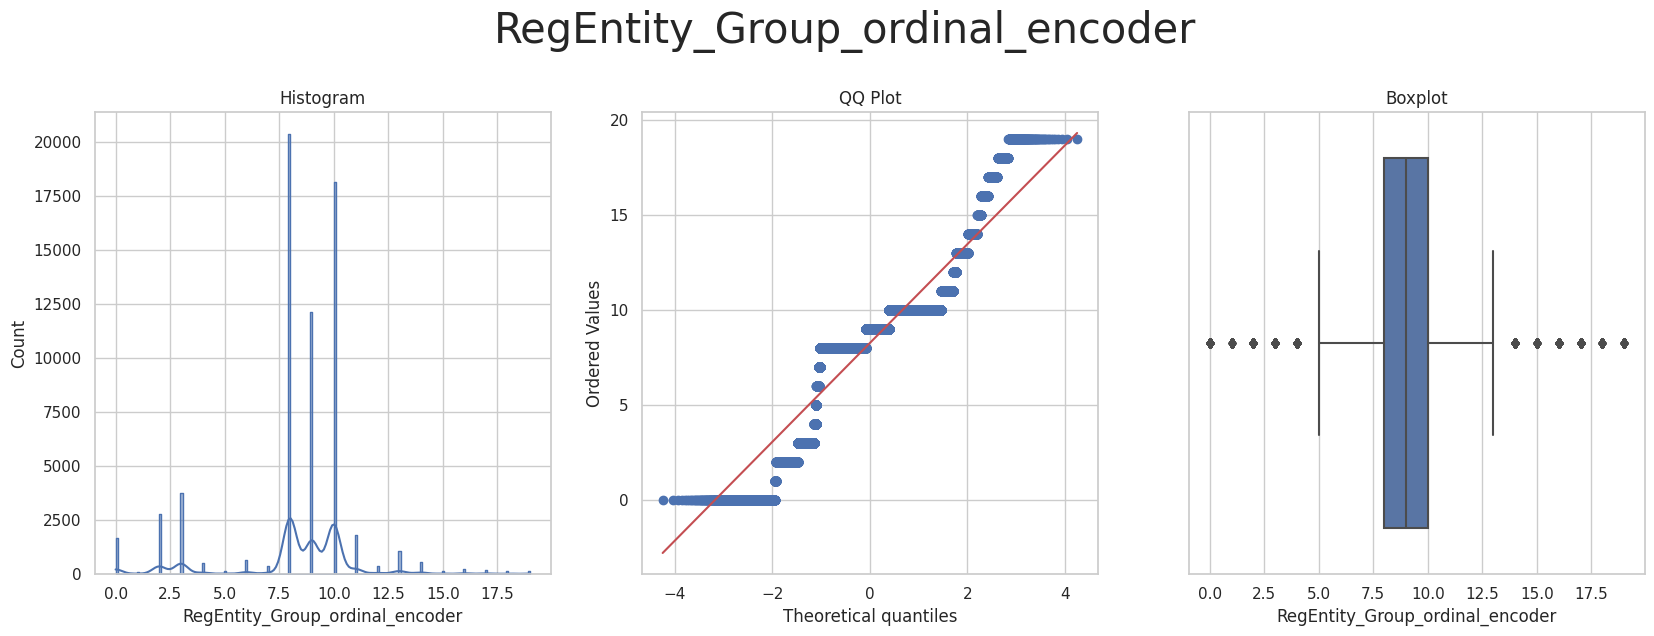



* Variable Analyzed: Value_Category
* Applied transformation: ['Value_Category_ordinal_encoder'] 



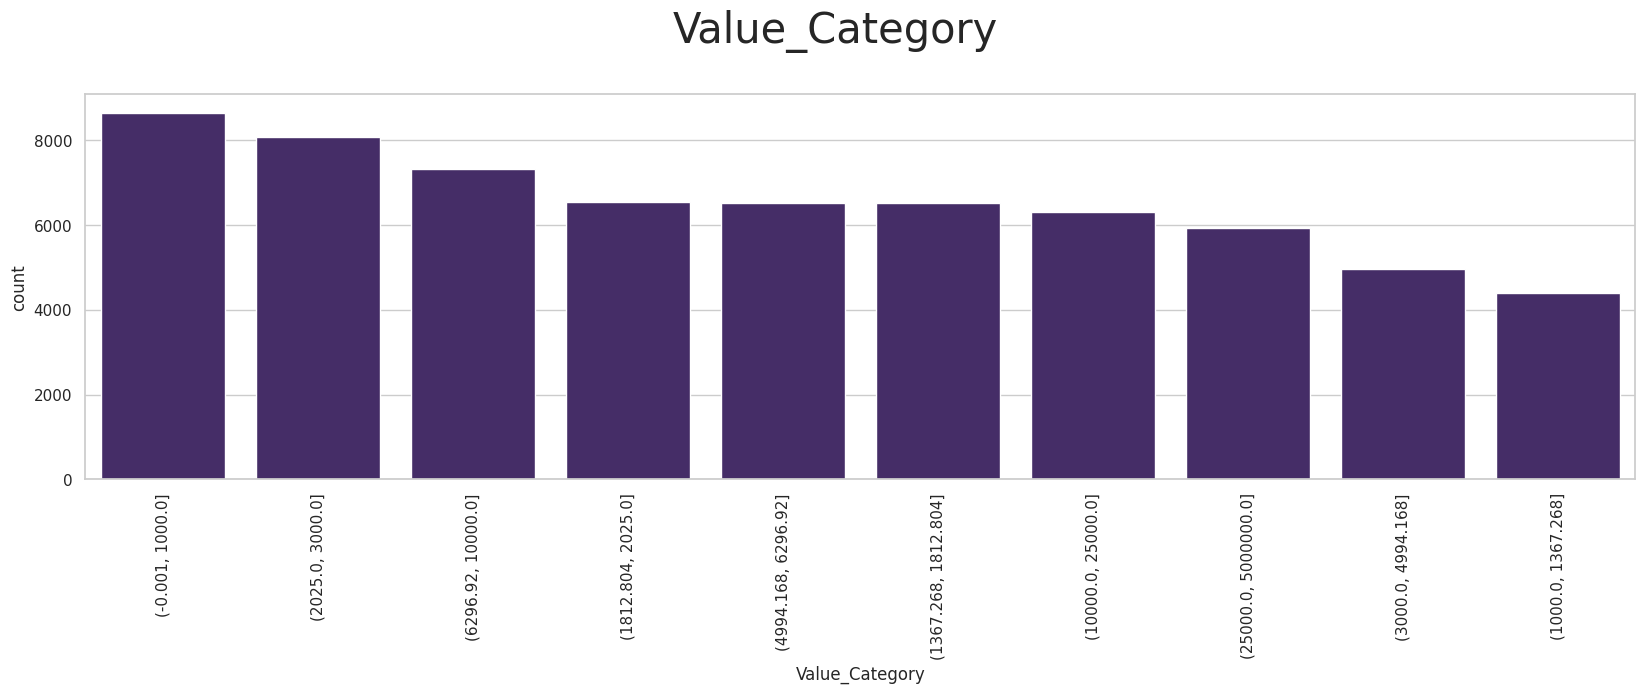

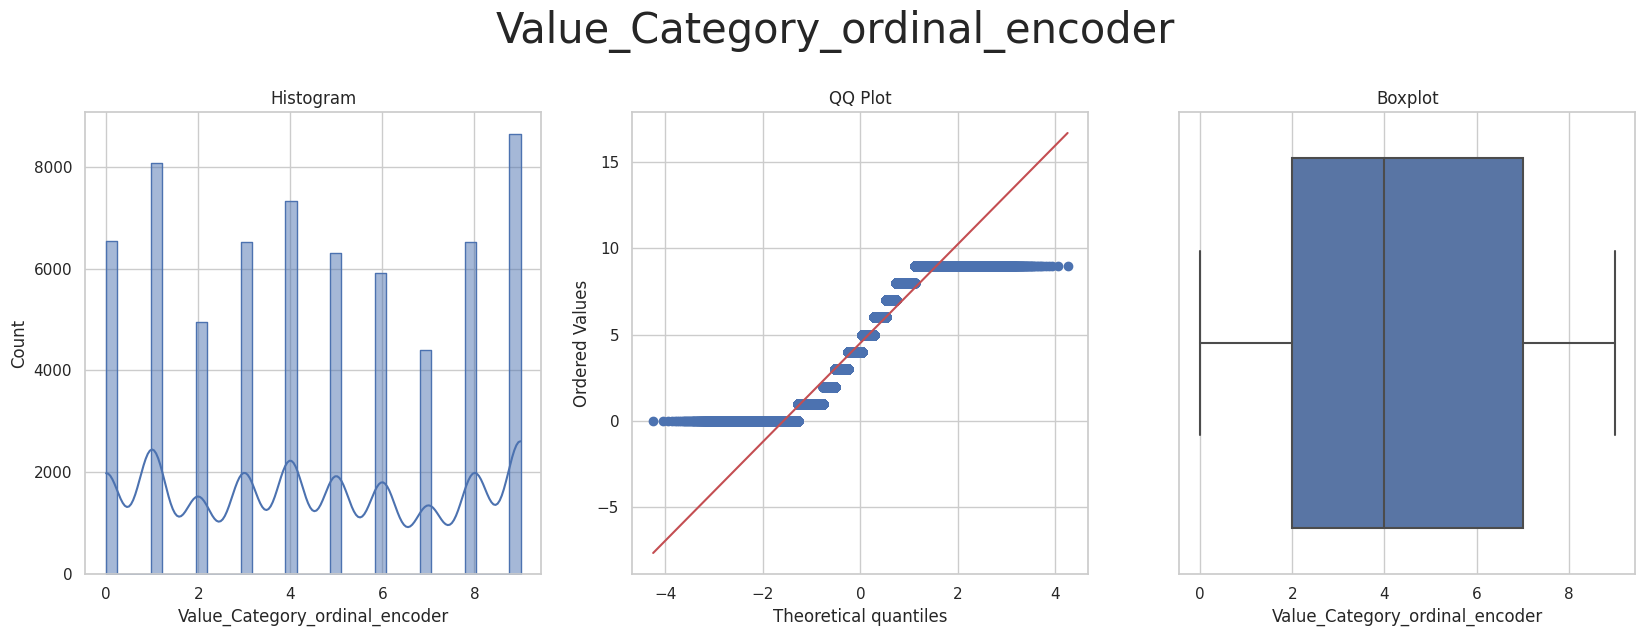



* Variable Analyzed: DonorStatus
* Applied transformation: [] 



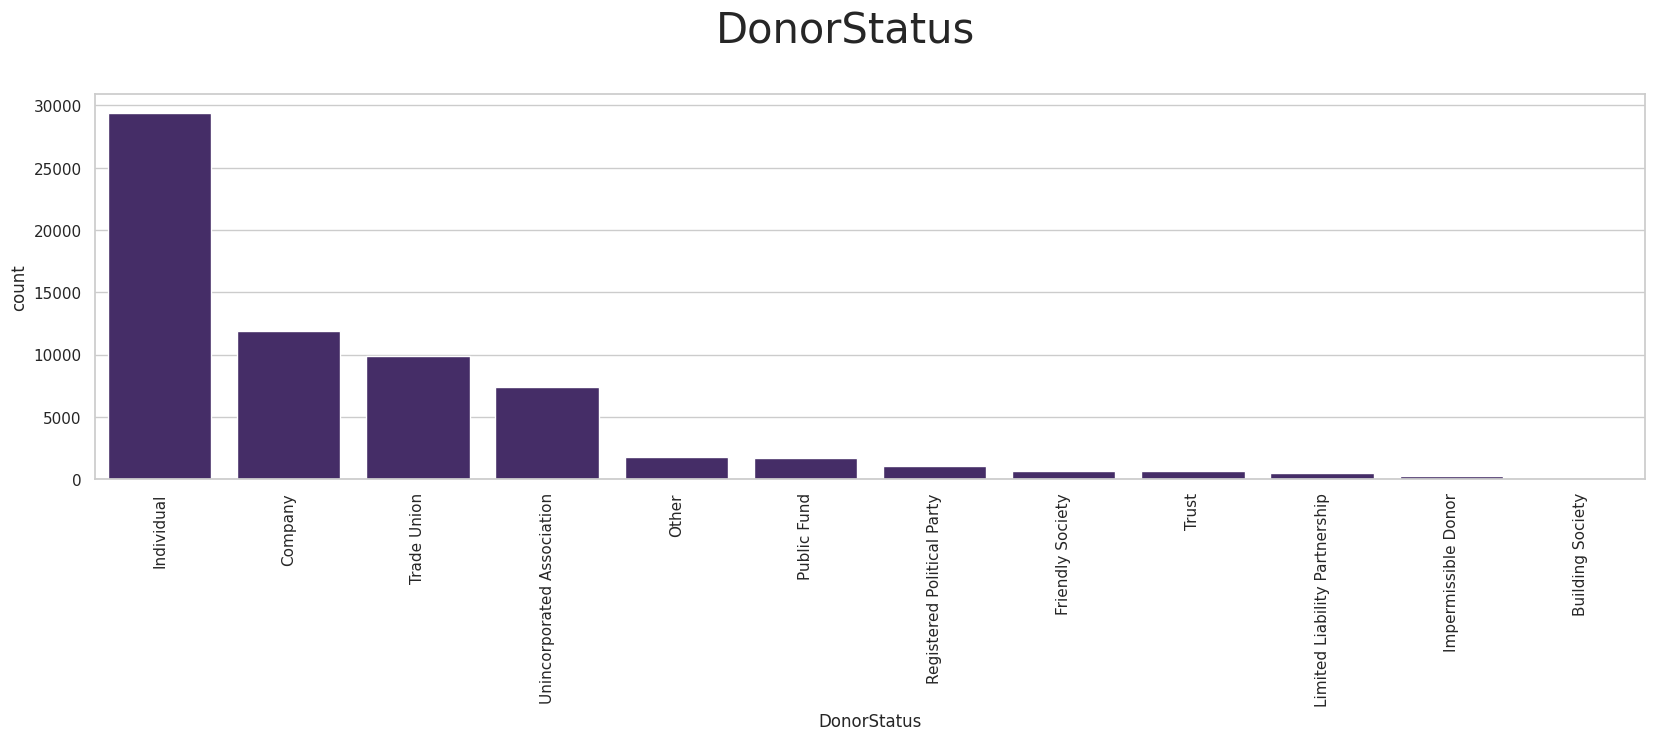

In [66]:
"""
 0   Value_Category             65193 non-null  category      
 1   ECRef                      65193 non-null  object        
 2   RegulatedEntityName        65193 non-null  string        
 3   RegulatedEntityType        65193 non-null  string        
 4   Value                      65193 non-null  float64       
 5   DonorName                  65193 non-null  string        
 6   IsSponsorship              65193 non-null  bool          
 7   DonorStatus                65193 non-null  string        
 8   RegulatedDoneeType         7089 non-null   string        
 9   CompanyRegistrationNumber  11480 non-null  string        
 10  Postcode                   35013 non-null  string        
 11  DonationType               65193 non-null  string        
 12  NatureOfDonation           10104 non-null  string        
 13  DonationAction             256 non-null    string        
 14  ReceivedDate               65193 non-null  datetime64[ns]
 15  ReportingPeriodName        65193 non-null  string        
 16  IsBequest                  65193 non-null  bool          
 17  IsAggregation              65193 non-null  bool          
 18  RegulatedEntityId          65193 non-null  string        
 19  DonorId                    65193 non-null  object        
 20  YearReceived               65193 non-null  float64       
 21  MonthReceived              65193 non-null  float64       
 22  YearMonthReceived          65193 non-null  float64     
"""
variables_engineering= ['RegEntity_Group', 'Value_Category', 'DonorStatus']
df_engineering = df[variables_engineering].copy()
# 'numerical', 'ordinal_encoder',  'outlier_winsorizer'
df_engineering = FeatureEngineeringAnalysis(df=df_engineering.dropna(),analysis_type='ordinal_encoder')

* Variable Analyzed: Value
* Applied transformation: ['Value_iqr'] 



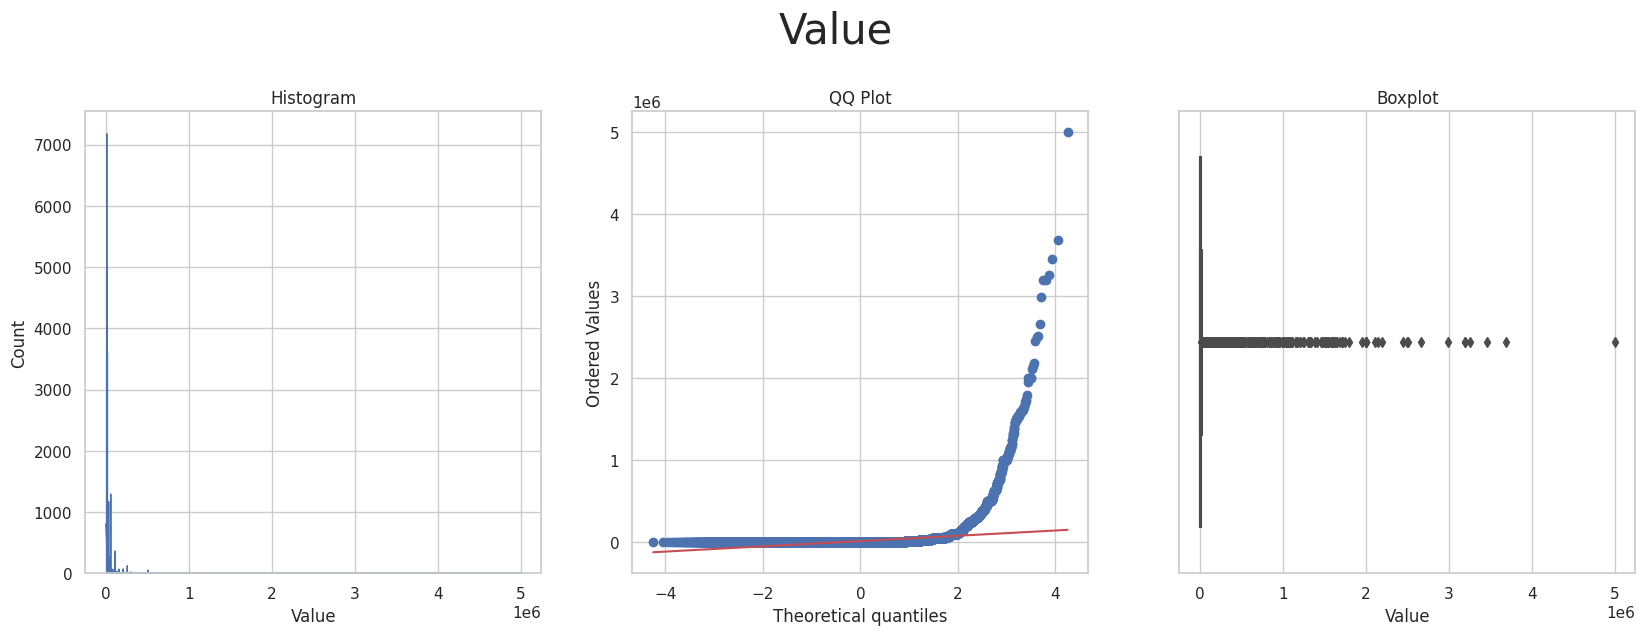

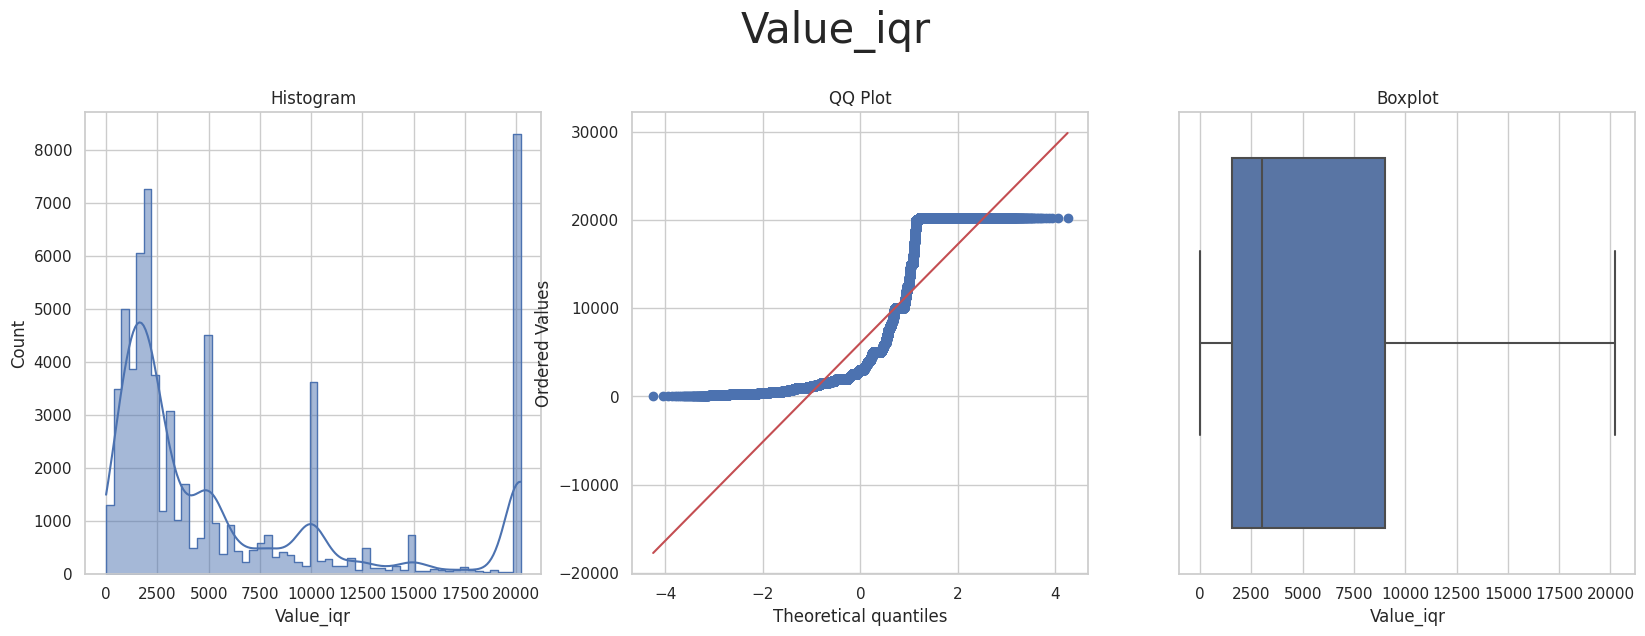

In [67]:
"""
 0   Value_Category             65193 non-null  category      
 1   ECRef                      65193 non-null  object        
 2   RegulatedEntityName        65193 non-null  string        
 3   RegulatedEntityType        65193 non-null  string        
 4   Value                      65193 non-null  float64       
 5   DonorName                  65193 non-null  string        
 6   IsSponsorship              65193 non-null  bool          
 7   DonorStatus                65193 non-null  string        
 8   RegulatedDoneeType         7089 non-null   string        
 9   CompanyRegistrationNumber  11480 non-null  string        
 10  Postcode                   35013 non-null  string        
 11  DonationType               65193 non-null  string        
 12  NatureOfDonation           10104 non-null  string        
 13  DonationAction             256 non-null    string        
 14  ReceivedDate               65193 non-null  datetime64[ns]
 15  ReportingPeriodName        65193 non-null  string        
 16  IsBequest                  65193 non-null  bool          
 17  IsAggregation              65193 non-null  bool          
 18  RegulatedEntityId          65193 non-null  string        
 19  DonorId                    65193 non-null  object        
 20  YearReceived               65193 non-null  float64       
 21  MonthReceived              65193 non-null  float64       
 22  YearMonthReceived          65193 non-null  float64     
"""
variables_engineering= ['Value']
df_engineering = df[variables_engineering].copy()
# 'numerical', 'ordinal_encoder',  'outlier_winsorizer'
df_engineering = FeatureEngineeringAnalysis(df=df_engineering.dropna(),analysis_type='outlier_winsorizer')

In [18]:
# Create Summary by DonorId of Total Value of Donations per Year.
df_donoryearValue =df.pivot_table(index='DonorId', columns='YearReceived',values='Value',aggfunc='sum')
# Create Datafile of Donors by Year showing number of donations
df_donoryearDonations = df.pivot_table(index='DonorId', columns='YearReceived',values='Value',aggfunc='count')
# Show Donations Value per year
df_donoryearValue.rename_axis('DonorId').reindex()
df_donoryearDonations.rename_axis('DonorId').reindex()
print(df_donoryearDonations.info())

df_donoryearDonations

<class 'pandas.core.frame.DataFrame'>
Index: 44736 entries, 1.0 to 9999.0
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2001.0  2509 non-null   float64
 1   2002.0  1662 non-null   float64
 2   2003.0  2089 non-null   float64
 3   2004.0  3110 non-null   float64
 4   2005.0  4246 non-null   float64
 5   2006.0  2878 non-null   float64
 6   2007.0  3924 non-null   float64
 7   2008.0  3982 non-null   float64
 8   2009.0  5012 non-null   float64
 9   2010.0  4412 non-null   float64
 10  2011.0  1493 non-null   float64
 11  2012.0  1326 non-null   float64
 12  2013.0  1502 non-null   float64
 13  2014.0  2434 non-null   float64
 14  2015.0  2937 non-null   float64
 15  2016.0  2241 non-null   float64
 16  2017.0  2697 non-null   float64
 17  2018.0  1523 non-null   float64
 18  2019.0  1116 non-null   float64
dtypes: float64(19)
memory usage: 6.8+ MB
None


YearReceived,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
DonorId,,,,,,,,,,,,,,,,,,,
1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
